# Create Tritium-$^3$He initial fields for CESM1.2.2
Created by Ivan Lima on Thu, 16 Jun 2016 09:03:31 -0400

Tritium is set to increase with latitude and decrease with depth and helium 3 is set to solubility equilibrium values for initial temperature and salinity.

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os, netCDF4, gsw
from datetime import datetime
from tr3he import *
%matplotlib inline

def make_cyclic(lon,lat,data):
    """
    Make data and coordinates cyclic
    """
    lon2 = np.hstack((lon,lon[:,0,np.newaxis]))
    lat2 = np.hstack((lat,lat[:,0,np.newaxis]))
    data2 = ma.concatenate((data,data[...,0,np.newaxis]),axis=-1)
    return lon2, lat2, data2

## Get grid dimensions and land mask from ecosys init file

In [2]:
datadir = '/bali/data/ilima/cesm/cesm1_input/ocn/pop/gx1v6/ic'
infile = os.path.join(datadir,'ecosys_jan_IC_gx1v6_corrO2_Feb2013.nc')
fpin = netCDF4.Dataset(infile,'r')
nz   = len(fpin.dimensions['z_t'])
nlat = len(fpin.dimensions['nlat'])
nlon = len(fpin.dimensions['nlon'])
zt   = fpin.variables['z_t'][:] / 100 # cm -> m
tlat = fpin.variables['TLAT'][:]
tlon = fpin.variables['TLONG'][:]
#fpin.close()
tlon2 = np.where(tlon>180,tlon-360,tlon) # 0:360 -> -180:180

## Read init file for temperature and salinity

In [3]:
datadir = '/bali/data/ilima/cesm/cesm1_input/ocn/pop/gx1v6/ic'
infile = os.path.join(datadir,'ts_PHC2_jan_ic_gx1v6_20090205.ieeer8')
data = np.fromfile(infile,dtype='>f8').reshape(2,nz,nlat,nlon)
data = ma.masked_less_equal(data,-99)
temp, salt = data[0,...], data[1,...]

### Surface temperature & salinity maps:

Self-intersection at or near point -147.68764957192516 89.260213100955795
Self-intersection at or near point 144.86043215161169 89.593276653476735
Self-intersection at or near point -147.68764957192516 89.260213100955795
Self-intersection at or near point 144.86043215161169 89.593276653476735


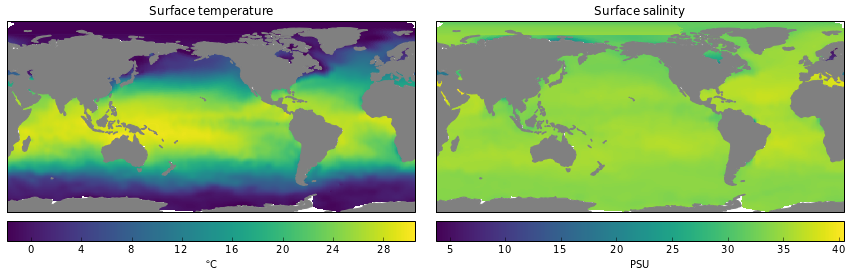

In [4]:
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180+30)},
                        figsize=(15,6))
fig.subplots_adjust(wspace=0.05)
axs = axs.ravel()
axs[0].add_feature(cfeature.LAND,facecolor='gray')
pm = axs[0].pcolormesh(tlon2,tlat,temp[0,...],transform=ccrs.PlateCarree())
axs[0].set(title='Surface temperature')
cb = fig.colorbar(pm,ax=axs[0],orientation='horizontal',pad=0.025)
cb.set_label(r'$^{\circ}$C')
axs[1].add_feature(cfeature.LAND,facecolor='gray')
pm = axs[1].pcolormesh(tlon2,tlat,salt[0,...],transform=ccrs.PlateCarree())
axs[1].set(title='Surface salinity')
cb = fig.colorbar(pm,ax=axs[1],orientation='horizontal',pad=0.025)
cb.set_label(r'PSU')

## Initial tritium & $^3$He fields

### Tritium field (in TU)

In [5]:
# Surface tritium decreases with latitude (in TU)
#tr_surf = 0.001 * np.exp(0.025*tlat)
#tr_surf = tr_surf/tr_surf.max() * 3
tr_surf = 0.001 * np.exp(0.03*tlat)
tr_surf = tr_surf/tr_surf.max() * 6
# Tritium concentration decreases exponentially with depth
z3d = np.ones(temp.shape) * zt[:,np.newaxis,np.newaxis]
tr0 = tr_surf[np.newaxis,:,:] * np.exp(-0.003*z3d)
tr0 = ma.array(tr0,mask=temp.mask)

Convert from TU to pmol m$^{-3}$.

$$ \left[^3\!H\right] \left(\frac{\textrm{pmols of}\;^3\!H}{\textrm{m}^3}\right) = \frac{2\rho}{M} \left(1-\frac{S}{1000}\right) 10^{-6} \left[^3\!H\right] \left(\textrm{TU}\right) $$

$\rho =$ density of seawater (kg m$^{-3}$), $M =$ molecular weight of water (kg mol$^{-1}$) and $S =$ salinity (PSU).

In [6]:
#pres = gsw.p_from_z(-zt[:,np.newaxis,np.newaxis],tlat[np.newaxis,:,:])
rho = gsw.rho(salt,temp,0)          # potential density
rho_star = rho * (1 - salt/1000)    # density of water in seawater
tu2mol = 2 * rho_star / M * 1.e-18  # conversion factor
tr0pmol = tr0 * tu2mol * 1.e+12

#### Tritium map & vertical profiles

Self-intersection at or near point -147.68764957192516 89.260213100955795
Self-intersection at or near point 144.86043215161169 89.593276653476735


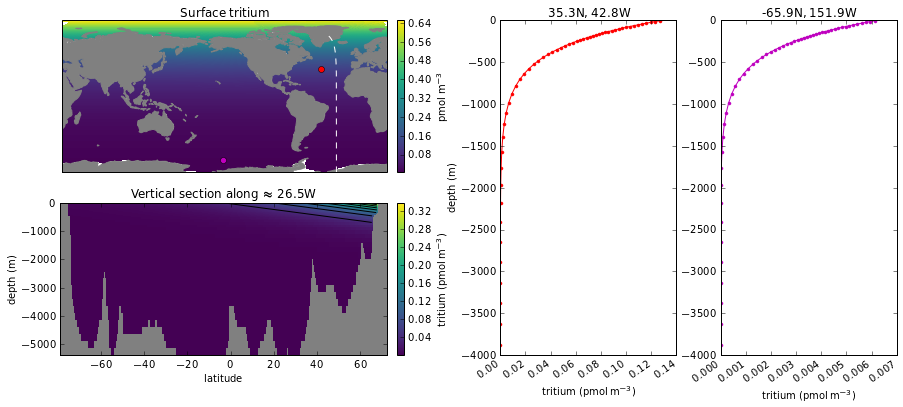

In [7]:
i1, j1 = 291, 317
i2, j2 = 25, 220
jj = 12
fig = plt.figure(figsize=(15,6))
fig.subplots_adjust(wspace=0.25)
ax1  = plt.subplot2grid([2,4],[0,0],colspan=2,projection=ccrs.PlateCarree(central_longitude=180+30))
ax1.add_feature(cfeature.LAND,facecolor='gray')
pm = ax1.pcolormesh(tlon2,tlat,tr0pmol[0,...],transform=ccrs.PlateCarree())
ax1.plot(tlon2[i1,j1],tlat[i1,j1],'ro',transform=ccrs.PlateCarree())
ax1.plot(tlon2[i2,j2],tlat[i2,j2],'mo',transform=ccrs.PlateCarree())
ax1.plot(tlon2[:,jj],tlat[:,jj],'w--',transform=ccrs.PlateCarree())
ax1.set(title='Surface tritium')
cb = fig.colorbar(pm,ax=ax1,pad=0.025)
cb.set_label('pmol m$^{-3}$')
ax2  = plt.subplot2grid([2,4],[0,2],rowspan=2)
ax2.plot(tr0pmol[:,i1,j1],-zt,'r.-')
ax2.set(title=r'%.1fN, %.1fW'%(tlat[i1,j1],-tlon2[i1,j1]),xlabel='tritium (pmol m$^{-3}$)',ylabel='depth (m)')
l = plt.setp(ax2.get_xticklabels(),rotation=35,horizontalalignment='right')
ax3  = plt.subplot2grid([2,4],[0,3],rowspan=2,sharey=ax2)
ax3.plot(tr0pmol[:,i2,j2],-zt,'m.-')
ax3.set(title=r'%.1fN, %.1fW'%(tlat[i2,j2],-tlon2[i2,j2]),xlabel='tritium (pmol m$^{-3}$)')
l = plt.setp(ax3.get_xticklabels(),rotation=35,horizontalalignment='right')
ax4 = plt.subplot2grid([2,4],[1,0],colspan=2)
pm = ax4.pcolormesh(tlat[:,jj],-zt,tr0pmol[:,:,jj])
cl = ax4.contour(tlat[:,jj],-zt,tr0pmol[:,:,jj],10,colors='k',lw=0.5)
ax4.set(title=r'Vertical section along $\approx$ %.1fW'%(-tlon2[:,jj].mean()),xlabel='latitude',ylabel='depth (m)')
ax4.set_axis_bgcolor('gray')
cb = fig.colorbar(pm,ax=ax4,pad=0.025)
cb.set_label('tritium (pmol m$^{-3}$)')

### $^3$He field

The $^3$He equilibrium concentration ($^3\!He_{eq}$) is computed as the $^4$He equilibrium concentration ($^4\!He_{eq}$) times the $^3$He/$^4$He isotopic ratio ($I_r$) and the temperature-dependent solubility fractionation factor ($\alpha_S$). 

$$ ^4\!He_{eq} = K_h X_{He} P_{atm} $$

$$ ^3\!He_{eq} =\,^4\!He_{eq}\,I_r\,\alpha_S $$

$K_h$ is the $^4$He solubility (mol m$^{-3}$ Pa$^{-1}$), $X_{He}$ is the $^4$He atmospheric mole fraction and $P_{atm}$ is the atmospheric pressure (Pa).

In [8]:
patm = 101325 # 1 atm in Pa
he4_sol = comp_henry_he_sol_0(temp,salt)
alpha_sol = alpha_sol_he(temp)
he4_sat = he4_sol * Xhe * patm
he3_sat = he4_sat * Ir * alpha_sol * 1.e+12 # mol/m^3 -> pmol/m^3

#### $^3$He map & vertical profile

Self-intersection at or near point -147.68764957192516 89.260213100955795
Self-intersection at or near point 144.86043215161169 89.593276653476735


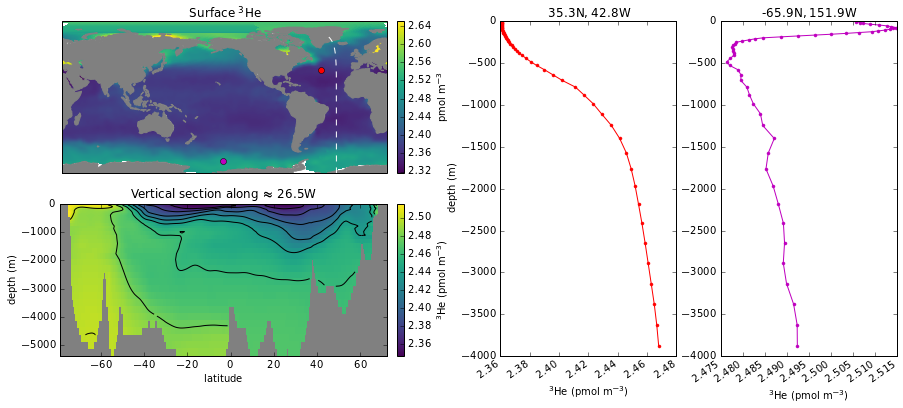

In [9]:
fig = plt.figure(figsize=(15,6))
fig.subplots_adjust(wspace=0.25)
ax1  = plt.subplot2grid([2,4],[0,0],colspan=2,projection=ccrs.PlateCarree(central_longitude=180+30))
ax1.add_feature(cfeature.LAND,facecolor='gray')
lon, lat, data = make_cyclic(tlon2,tlat,he3_sat[0,...])
pm = ax1.pcolormesh(lon,lat,data,transform=ccrs.PlateCarree(),vmax=2.65)
ax1.plot(tlon2[i1,j1],tlat[i1,j1],'ro',transform=ccrs.PlateCarree())
ax1.plot(tlon2[i2,j2],tlat[i2,j2],'mo',transform=ccrs.PlateCarree())
ax1.plot(tlon2[:,jj],tlat[:,jj],'w--',transform=ccrs.PlateCarree())
ax1.set(title='Surface $^3$He')
cb = fig.colorbar(pm,ax=ax1,pad=0.025)
cb.set_label('pmol m$^{-3}$')
ax2  = plt.subplot2grid([2,4],[0,2],rowspan=2)
ax2.plot(he3_sat[:,i1,j1],-zt,'r.-')
ax2.set(title=r'%.1fN, %.1fW'%(tlat[i1,j1],-tlon2[i1,j1]),xlabel='$^3$He (pmol m$^{-3}$)',ylabel='depth (m)')
l = plt.setp(ax2.get_xticklabels(),rotation=35,horizontalalignment='right')
ax3  = plt.subplot2grid([2,4],[0,3],rowspan=2,sharey=ax2)
ax3.plot(he3_sat[:,i2,j2],-zt,'m.-')
ax3.set(title=r'%.1fN, %.1fW'%(tlat[i2,j2],-tlon2[i2,j2]),xlabel='$^3$He (pmol m$^{-3}$)')
l = plt.setp(ax3.get_xticklabels(),rotation=35,horizontalalignment='right')
ax4 = plt.subplot2grid([2,4],[1,0],colspan=2)
pm = ax4.pcolormesh(tlat[:,jj],-zt,he3_sat[:,:,jj])
cl = ax4.contour(tlat[:,jj],-zt,he3_sat[:,:,jj],10,colors='k',lw=0.5)
ax4.set(title=r'Vertical section along $\approx$ %.1fW'%(-tlon2[:,jj].mean()),xlabel='latitude',ylabel='depth (m)')
ax4.set_axis_bgcolor('gray')
cb = fig.colorbar(pm,ax=ax4,pad=0.025)
cb.set_label('$^3$He (pmol m$^{-3}$)')

## Write fields to netCDF file

In [10]:
outfile = os.path.join(datadir,'tritium_3He_init_sat.nc')
if os.path.isfile(outfile):
    os.remove(outfile)

fpout = netCDF4.Dataset(outfile,'w',format='NETCDF3_CLASSIC')
fpout.contents = """Initial tritium and 3He fields for CESM. 
Helium 3 is set to solubility equilibrium values for 
initial temperature and salinity (%s)."""%os.path.basename(infile)
fpout.history = 'Created by Ivan Lima <ivan@whoi.edu> on %s'%datetime.now().ctime()

for dim in ['z_t','nlat','nlon','Y','X']:
    fpout.createDimension(dim,len(fpin.dimensions[dim]))

for vname in ['z_t','TLAT','TLONG','KMT']:
    ncvar = fpout.createVariable(vname,fpin.variables[vname][:].dtype.char,fpin.variables[vname].dimensions)
    for attr in fpin.variables[vname].ncattrs():
        setattr(ncvar,attr,getattr(fpin.variables[vname],attr))
    ncvar[:] = fpin.variables[vname][:]
    
ncvar = fpout.createVariable('TRITIUM','f',('z_t','nlat','nlon'),fill_value=tr0.fill_value)
ncvar.missing_value = tr0.fill_value
ncvar.long_name = 'tritium'
ncvar.units = 'pmol/m^3'
ncvar.coordinates = 'TLONG TLAT z_t time'
ncvar[:] = tr0pmol.astype(np.float32)

ncvar = fpout.createVariable('HELIUM3','f',('z_t','nlat','nlon'),fill_value=he3_sat.fill_value)
ncvar.missing_value = he3_sat.fill_value
ncvar.long_name = 'helium 3'
ncvar.units = 'pmol/m^3'
ncvar.coordinates = 'TLONG TLAT z_t time'
ncvar[:] = he3_sat.astype(np.float32)

fpin.close()
fpout.close()